# Double Well Potential with MCMC


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import random
import time

start = time.process_time()

# Problem A
Evaluate the ground state energy and probability distribution of the particle using Markov chain Monte Carlo with the Metropolis-Hastings algorithm in the large-$τ_b$(imaginary time) limit. Describe your strategy for determining τ, the initial configuration, burn-in steps, hit size, number of sweeps, and thinning (if any).

In [2]:
# defining constants
alpha = 0.4 

# setting the position ranges 
xlow = - 4 # min x 
xhigh = 4 # max x 
n_xbins = 100 # number of x steps
dx = (xhigh - xlow) / n_xbins # size of x step
x_bins = np.linspace(xlow, xhigh, n_xbins + 1) # x steps

### Defining functions for the double well potential and action.
Here, we are using action as the total energy because of the definition of a lagrangian. 

In [3]:
def potential(x):
    
    """
    Defining the potential at some point x
    x: the value at which to determine the potential
    Returns: the double well potential, at that point
    """
    return (alpha * x ** 4) - (2 * x ** 2) + (1 / alpha)

def vary_path(x_current, hitsize):
    
    """
    Picking a random point in the domain.
    x_current: the current point in the x-domain
    Returns: a new point, randomly picked
    """
    x_prime = x_current + np.random.random() * 2 * hitsize - hitsize
    
    while x_prime > xhigh or x_prime < xlow:
        x_prime = x_current + np.random.random() * 2 * hitsize - hitsize
        
    return x_prime

# here I defined the action based on the lagrangian in the final project. 
# this is the exponential portion of eq 3 and 4
def action(x_left, x_right, dtau):
    """
    Determining the action from a left and right point.
    x_left: the left limit of the action potential
    x_right: the right limit of the action potential
    dtau: step size in tau
    Returns: the action
    """
    k = 0.5 * (((x_right - x_left)) ** 2) / dtau
    v = dtau * potential(((x_left + x_right) / 2))
    return k + v

def delta_action(x_path, prime, i, dtau):
    """
    Determining the difference in action4 across some point and in comparison to another point.
    x_path: the path across which to determine the action
    prime: the other point to compare the action to
    i: the index of the point to compare actions across
    dtau: step size in tau
    Returns: the action difference 
    """
    left = x_path[i - 1]
    right = x_path[i + 1] if i < ntau - 1 else x_path[0] 
    daction = action(left, prime, dtau) + action(prime, right, dtau)
    daction -= (action(left, x_path[i], dtau) + action(x_path[i], right, dtau))

    return daction

In [46]:
def mcmc(x_path, mean_energies, prob_histogram, n_accept, tau = 3000, 
         dtau = 2, hitsize = 0.8, thinning_val = 1): 
    """
    Applying MCMC algorithm to path to find ground state energy, 
    proportional to the sum of the total action over the number of time steps.

    x_path: the path across which to apply the MCMC algorithm
    mean_energies: array to save energy values to
    prob_histogram: array to save probability values to
    n_accept: number of accepted values
    tau: imaginary time for algorithm to run across 
    dtau: step size for tau
    hitsize: random interval size to generate value from
    thinning_val: value used to consider for thinning the algorithm, default one
    
    Return: number of accepted values
    """
    ntau = int(tau / dtau)

    energy = 0
    
    for i in range(0, ntau, thinning_val):
        
        x_prime = vary_path(x_path[i], hitsize)  # updated particle position
        daction = delta_action(x_path, x_prime, i, dtau)
        
        if daction <= 0: 
            x_path[i] = x_prime
            left = x_path[i - 1]
            right = x_path[i + 1] if i < ntau - 1 else x_path[0] 
            energy += action(left, right, dtau)
            n_accept += 1
            
        else:     
            prob = np.exp(-daction)
            if np.random.random() < prob:
                x_path[i] = x_prime
                left = x_path[i - 1]
                right = x_path[i + 1] if i < ntau - 1 else x_path[0]
                energy += action(left, right, dtau)
                n_accept += 1
            else:
                left = x_path[i - 1]
                right = x_path[i + 1] if i < ntau - 1 else x_path[0]
                energy += action(left, right, dtau)
                
    mean_energies.append(energy / ntau)
    hist, _ = np.histogram(x_path, bins = x_bins)
    prob_histogram += hist
    return n_accept

### Parameters that we can change 

In [47]:
sweeps = 1000 # number of iterations 
tau = 3000
dtau = 2.5
ntau = int(tau/dtau) # number of time steps
hitsize = 0.8

### COLD START 
Define cold start as half of the particles starting in either minima of the double potential well. 

In [48]:
x_path_cold = [-np.sqrt(1/alpha)] * int(ntau/2) + [np.sqrt(1/alpha)] * int(ntau/2)

mean_energies_cold = []
prob_histogram_cold = np.zeros(n_xbins)
n_accept_cold = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept_cold = mcmc(x_path_cold, mean_energies_cold, prob_histogram_cold, n_accept_cold, 
                         tau = tau, dtau = dtau, hitsize = hitsize)

print(n_accept_cold / (sweeps * ntau))

100%|██████████| 1000/1000 [00:13<00:00, 76.75it/s]

0.5495566666666667


### HOT START 
Define hot start as the particles starting at random points between the minima of the double potential well. 
This takes forever to converge because of the randomization. Thus, a cold start is more efficient. With an initial guess that is close to the final result, or expected probability distribution, the faster the MCMC algorithm will converge. 

In [49]:
x_path_hot = np.random.choice([-1/np.sqrt(alpha), 1/np.sqrt(alpha)], ntau)

mean_energies_hot = []
prob_histogram_hot = np.zeros(n_xbins)
n_accept_hot = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept_hot = mcmc(x_path_hot, mean_energies_hot, prob_histogram_hot, n_accept_hot, 
                        tau = tau, dtau = dtau, hitsize = hitsize)
    
print(n_accept_hot / (sweeps * ntau))

100%|██████████| 1000/1000 [00:12<00:00, 78.02it/s]

0.5929358333333333


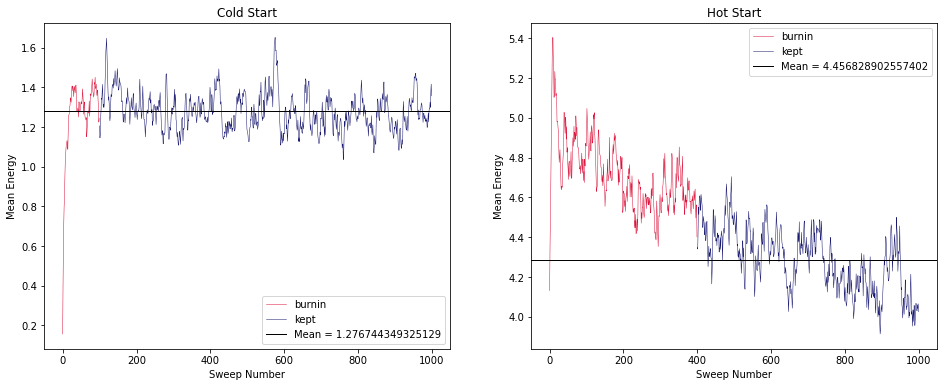

In [50]:
fig, ax = plt.subplots(1, 2, figsize = (16, 6))

ax[0].plot(range(len(mean_energies_cold))[:100], mean_energies_cold[:100], lw = 0.5, 
           color = 'crimson', label = 'burnin')
ax[0].plot(range(len(mean_energies_cold))[100:], mean_energies_cold[100:], lw = 0.5, 
           color = 'midnightblue', label = 'kept')
ax[0].axhline(np.mean(mean_energies_cold[100:]), lw = 1, color = 'black', 
              label = 'Mean = {}'.format(np.mean(mean_energies_cold)))
ax[0].set_xlabel('Sweep Number')
ax[0].set_ylabel('Mean Energy')
ax[0].set_title('Cold Start')
ax[0].legend()

ax[1].plot(range(len(mean_energies_hot))[:400], mean_energies_hot[:400], lw = 0.5, 
           color = 'crimson', label = 'burnin')
ax[1].plot(range(len(mean_energies_hot))[400:], mean_energies_hot[400:], lw = 0.5, 
           color = 'midnightblue', label = 'kept')
ax[1].axhline(np.mean(mean_energies_hot[400:]), lw = 1, color = 'black', 
              label = 'Mean = {}'.format(np.mean(mean_energies_hot)))
ax[1].set_xlabel('Sweep Number')
ax[1].set_ylabel('Mean Energy')
ax[1].set_title('Hot Start')
ax[1].legend()
plt.show()

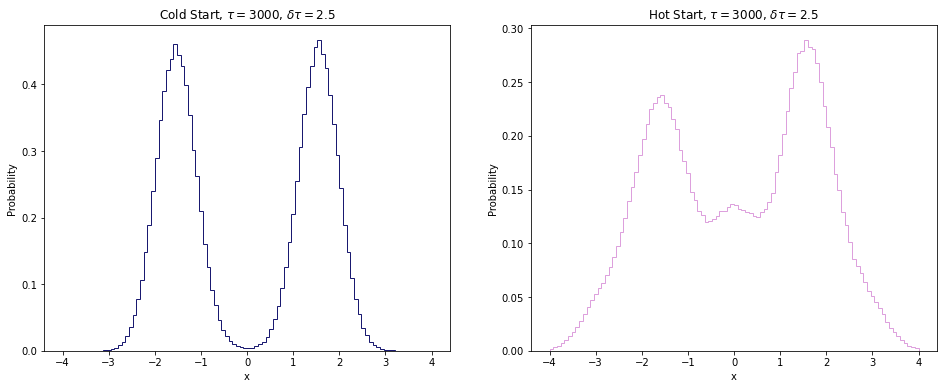

In [51]:
fig, ax = plt.subplots(1, 2,figsize = (16, 6))

ax[0].stairs(prob_histogram_cold / np.sum(prob_histogram_cold * dx), x_bins, color = 'midnightblue')
ax[0].set_title(f"Cold Start, $\\tau = {tau}$, $\delta\\tau= {dtau} $")
ax[0].set_xlabel('x')
ax[0].set_ylabel('Probability')

ax[1].stairs(prob_histogram_hot / np.sum(prob_histogram_hot * dx), x_bins, color = 'plum')
ax[1].set_title(f"Hot Start, $\\tau = {tau}$, $\delta\\tau= {dtau} $")
ax[1].set_xlabel('x')
ax[1].set_ylabel('Probability')
plt.show()

# Problem B

Comparing our MCMC Results to the analytic result from the power method. 
Our MCMC results seem to have better results than the analytic. In the analytic, it looks the particles are more dispersed in the well due to the higher probabilty in the middle. 

In [52]:
OMEGA = 1
BOXSIZE = 8
ND = 600
DELTAX = BOXSIZE / ND
HBAR = 1
ALPHA = 0.4

x = np.linspace(-BOXSIZE / 2, BOXSIZE / 2, ND + 1)

def V(x):
    return (ALPHA * x ** 4) - (2 * x ** 2) + (1 / ALPHA)

H = np.zeros((ND + 1, ND + 1)) # creating an empty matrix for the hamiltonian of size 601 x 601

for i in range(ND + 1):  # adding values to the hamiltonian matrix
    for j in range(ND + 1):
       # kinetic
        H[i, j] = -(0.5 / DELTAX**2) * ((i + 1 == j) - 2 * (i == j) + (i - 1 == j)) 
        # potential
        H[i, j] += V(x[i]) * (i == j)

In [53]:
# first 4x4 elements of H
print(H[:4,:4])

[[ 5697.9        -2812.5            0.             0.        ]
 [-2812.5         5696.75445595 -2812.5            0.        ]
 [    0.         -2812.5         5695.62176328 -2812.5       ]
 [    0.             0.         -2812.5         5694.50183142]]


In [54]:
# finding the ground state and ground energy using the power method 
import scipy
import scipy.sparse.linalg
n_iter = 30 

# initial conditions (pre-iteration)
u0 = [np.ones(ND + 1)]
lambda_0 = [np.dot(u0[-1].conjugate(), H @ u0[0]) / np.dot(u0[-1].conjugate(), u0[0])] # gives 0.5

Hinv = scipy.linalg.inv(H)  
for i in range(n_iter):
    u0.append(Hinv @ u0[-1])  # multiplying the inverse hamiltonian by the newest interation of u 
    u0[-1] /= (np.sum(u0[-1].conjugate() * u0[-1]) * DELTAX)  # updating u again 
    lambda_0.append(np.dot(u0[-1].conjugate(), H @ u0[-1]) / np.dot(u0[-1].conjugate(), u0[-1])) # updating lambda_0

E_0 = lambda_0[-1]
phi_0 = u0[-1]/np.sqrt(np.dot(np.conjugate(u0[-1]),u0[-1])* DELTAX)


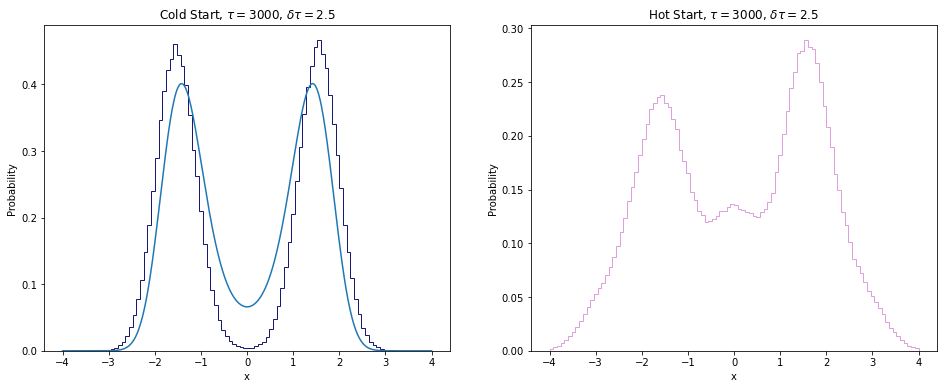

In [55]:
fig, ax = plt.subplots(1, 2,figsize = (16, 6))

ax[0].stairs(prob_histogram_cold / np.sum(prob_histogram_cold * dx), x_bins, color = 'midnightblue')
ax[0].plot(x,phi_0**2, label = 'analytic')
ax[0].set_title(f"Cold Start, $\\tau = {tau}$, $\delta\\tau= {dtau} $")
ax[0].set_xlabel('x')
ax[0].set_ylabel('Probability')

ax[1].stairs(prob_histogram_hot / np.sum(prob_histogram_hot * dx), x_bins, color = 'plum')
ax[1].plot(x,phi_0**2, label = 'analytic')
ax[1].set_title(f"Hot Start, $\\tau = {tau}$, $\delta\\tau= {dtau} $")
ax[1].set_xlabel('x')
ax[1].set_ylabel('Probability')
plt.show()

# Problem C 
Testing MCMC with a smaller imaginary time. For funsies, let's test a really drastic difference of $\tau$=50. Since $\tau$ = h$\beta$, and $\beta$ = 1/$k_b$T, this means that there is a now a significant amount of kinetic energy in the system. In other words, some particles are excited and are jumping to various states. We expect the energy to increase, meaning that the MCMC output of the system's energy is no longer just of the ground state.  

We see this reflected in the probability distribution as well. The probability becomes skewed towards either side of the potential well, which indicates that there is some excitation. 

In [26]:
sweeps = 1000 # number of iterations 
tau = 50
dtau = 2.5
ntau = int(tau/dtau) # number of time steps
hitsize = 0.8

In [27]:
# COLD START 
x_path_cold = [-np.sqrt(1/alpha)] * int(ntau/2) + [np.sqrt(1/alpha)] * int(ntau/2)

mean_energies_cold = []
prob_histogram_cold = np.zeros(n_xbins)
n_accept_cold = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept_cold = mcmc(x_path_cold, mean_energies_cold, prob_histogram_cold, n_accept_cold, 
                         tau = tau, dtau = dtau, hitsize = hitsize)

print(n_accept_cold / (sweeps * ntau))

# HOT START 
x_path_hot = np.random.choice([-1/np.sqrt(alpha), 1/np.sqrt(alpha)], ntau)

mean_energies_hot = []
prob_histogram_hot = np.zeros(n_xbins)
n_accept_hot = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept_hot = mcmc(x_path_hot, mean_energies_hot, prob_histogram_hot, n_accept_hot, 
                        tau = tau, dtau = dtau, hitsize = hitsize)
    
print(n_accept_hot / (sweeps * ntau))

100%|██████████| 1000/1000 [00:00<00:00, 3433.07it/s]


0.57865


100%|██████████| 1000/1000 [00:00<00:00, 3941.30it/s]

0.5995


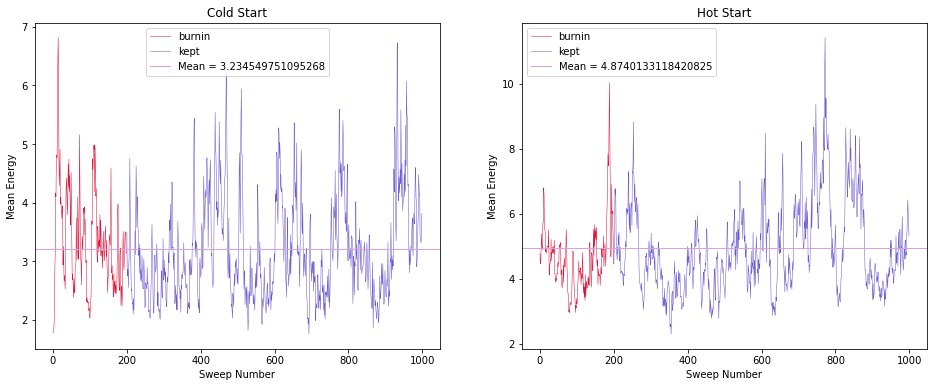

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (16, 6))

ax[0].plot(range(len(mean_energies_cold))[:200], mean_energies_cold[:200], lw = 0.5, 
           color = 'crimson', label = 'burnin')
ax[0].plot(range(len(mean_energies_cold))[200:], mean_energies_cold[200:], lw = 0.5, 
           color = 'slateblue', label = 'kept')
ax[0].axhline(np.mean(mean_energies_cold[200:]), lw = 1, color = 'plum', 
              label = 'Mean = {}'.format(np.mean(mean_energies_cold)))
ax[0].set_xlabel('Sweep Number')
ax[0].set_ylabel('Mean Energy')
ax[0].set_title('Cold Start')
ax[0].legend()

ax[1].plot(range(len(mean_energies_hot))[:200], mean_energies_hot[:200], lw = 0.5, 
           color = 'crimson', label = 'burnin')
ax[1].plot(range(len(mean_energies_hot))[200:], mean_energies_hot[200:], lw = 0.5, 
           color = 'slateblue', label = 'kept')
ax[1].axhline(np.mean(mean_energies_hot[200:]), lw = 1, color = 'plum', 
              label = 'Mean = {}'.format(np.mean(mean_energies_hot)))
ax[1].set_xlabel('Sweep Number')
ax[1].set_ylabel('Mean Energy')
ax[1].set_title('Hot Start')
ax[1].legend()
plt.show()

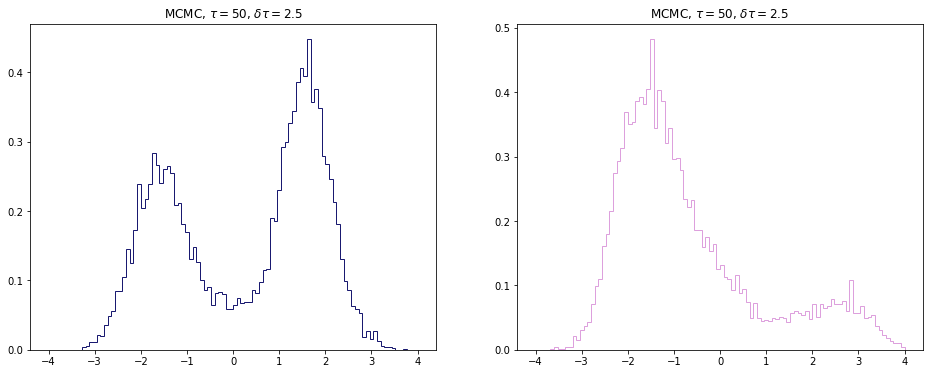

In [29]:
fig, ax = plt.subplots(1, 2,figsize = (16, 6))

ax[0].stairs(prob_histogram_cold / np.sum(prob_histogram_cold * dx), x_bins, color = 'midnightblue', label='cold start')
ax[0].set_title(f"MCMC, $\\tau = {tau}$, $\delta\\tau= {dtau} $")

ax[1].stairs(prob_histogram_hot / np.sum(prob_histogram_hot * dx), x_bins, color = 'plum', label='hot start')
ax[1].set_title(f"MCMC, $\\tau = {tau}$, $\delta\\tau= {dtau} $")

plt.show()
